
... ***CURRENTLY UNDER DEVELOPMENT*** ...


## HyCReeW-Q : Selection of extreme events (POT)

inputs required: 
  * Nearshore reconstructed historical **waves**
  * Historical water levels

in this notebook:
  * HyCReWW-Q overtopping estimation of historical events
  

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.stats import linregress
from datetime import datetime

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..', '..'))

# teslakit
from teslakit.database import Database
from teslakit.rbf import RBF_Interpolation
from teslakit.mda import Normalize
from teslakit.statistical import runmean
from teslakit.tides import Calculate_MMSL
from teslakit.extremes import Peaks_Over_Threshold as POT

from teslakit.plotting.tides import Plot_Tide_SLR, Plot_Tide_RUNM, Plot_Tide_MMSL



## Database and Site parameters

In [2]:
# --------------------------------------
# Teslakit database

p_data = r'/Users/albacid/Projects/TeslaKit_projects'
db = Database(p_data)

# set site
db.SetSite('KWAJALEIN')


# --------------------------------------
hist_Q_wavesH= xr.open_dataset(op.join(p_data, 'sites/KWAJALEIN/HYCREWW/hist_Q_wavesH.nc'))

print(hist_Q_wavesH)


<xarray.Dataset>
Dimensions:  (profile: 36, time: 157776)
Coordinates:
  * time     (time) datetime64[ns] 1996-01-17 ... 2014-01-15T23:00:00
  * profile  (profile) float64 1.0 2.0 3.0 4.0 5.0 ... 32.0 33.0 34.0 35.0 36.0
Data variables:
    hs       (profile, time) float64 ...
    tp       (profile, time) float64 ...
    dir      (profile, time) float64 ...
    bslope   (profile, time) float64 ...
    rslope   (profile, time) float64 ...
    rwidth   (profile, time) float64 ...
    cf       (profile, time) float64 ...
    Zb       (profile, time) float64 ...
    level    (profile, time) float64 ...
    hs_lo2   (profile, time) float64 ...
    Q        (profile, time) float64 ...
    Qinv     (profile, time) float64 ...


### Plot

In [3]:

# Remove values in each profile where Q<1 l/s (neglegible)
hist_Q_wavesH['Qinv'] = hist_Q_wavesH.Qinv.where(hist_Q_wavesH.Qinv.values>=1, 0)


# Sum all profiles
Q_all = hist_Q_wavesH.Qinv.sum(dim='profile')


# POT: Select all values where Qsum > 0 l/s
Q_all = Q_all.where(Q_all>0, np.nan)


# Select extreme events for each profile
for p in hist_Q_wavesH.profile.values:
    
    temp = hist_Q_wavesH.Qinv.sel(profile=p)
    temp = temp.where(~np.isnan(Q_all.values), np.nan)
    
    if p == 1:
        output = temp
    else:
        output = xr.concat([output, temp], dim='profile')
        
print(output)    


<xarray.DataArray 'Qinv' (profile: 36, time: 157776)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * time     (time) datetime64[ns] 1996-01-17 ... 2014-01-15T23:00:00
  * profile  (profile) float64 1.0 2.0 3.0 4.0 5.0 ... 32.0 33.0 34.0 35.0 36.0


SystemExit: 

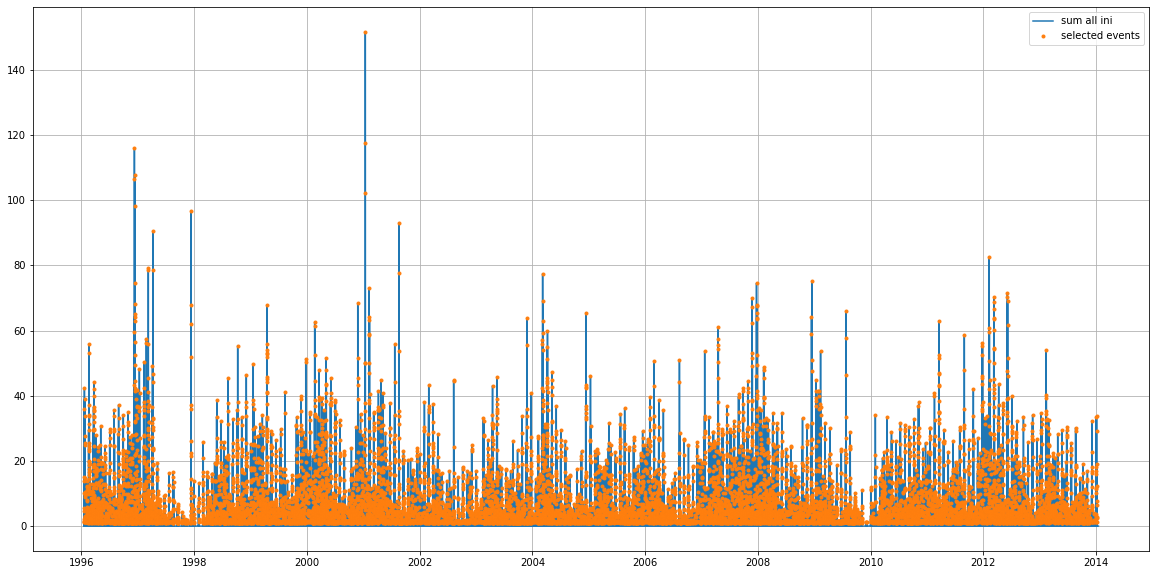

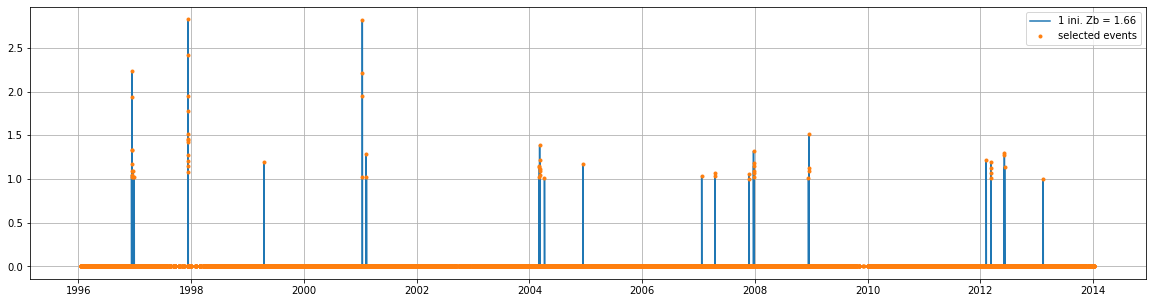

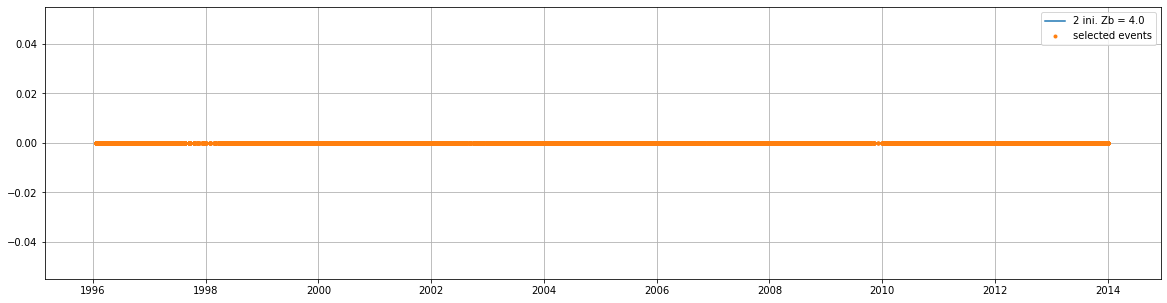

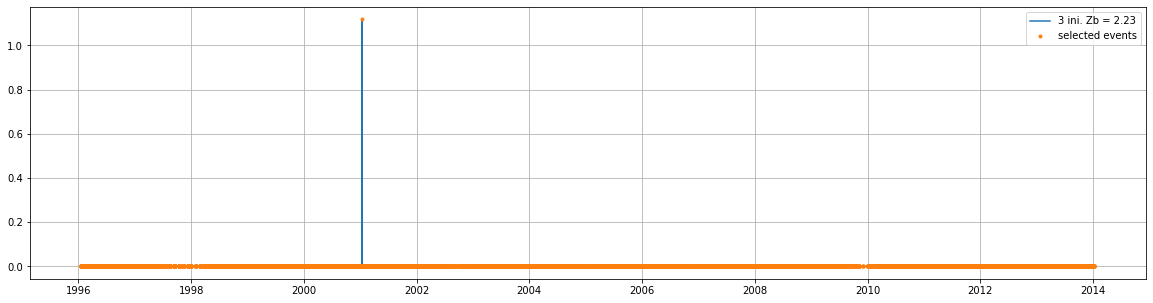

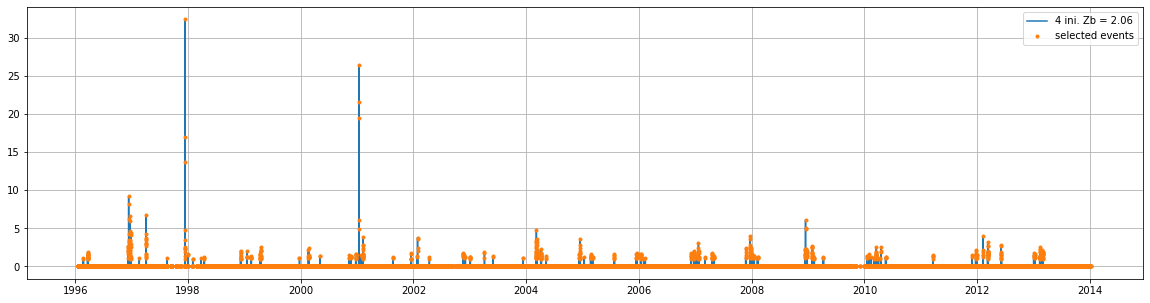

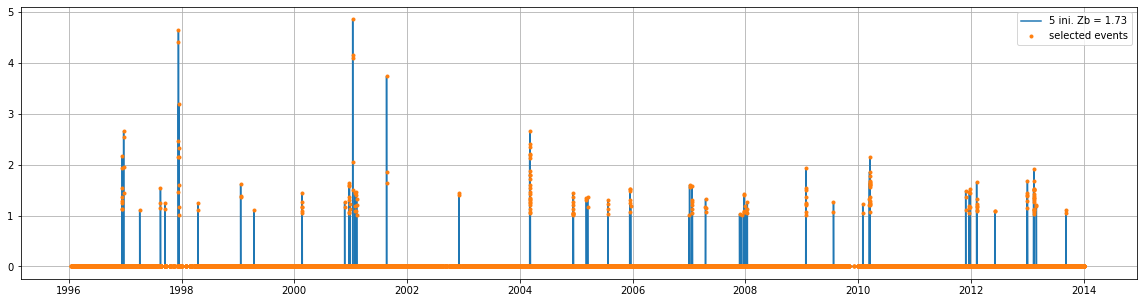

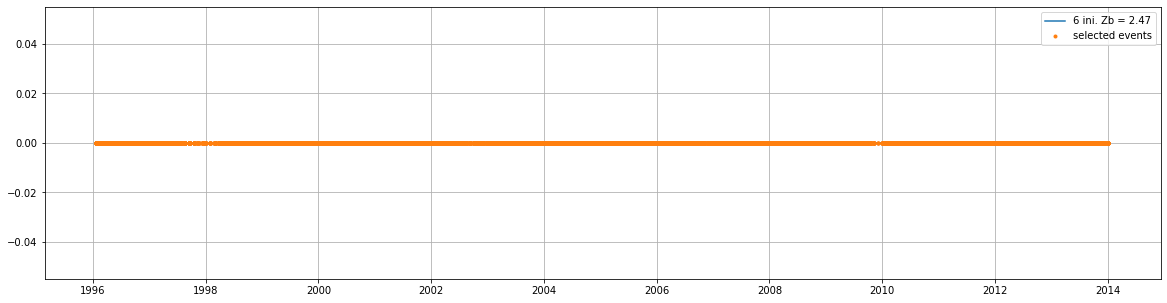

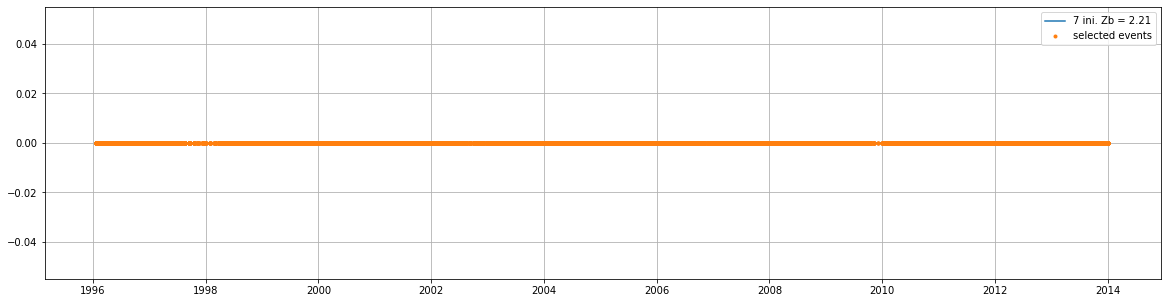

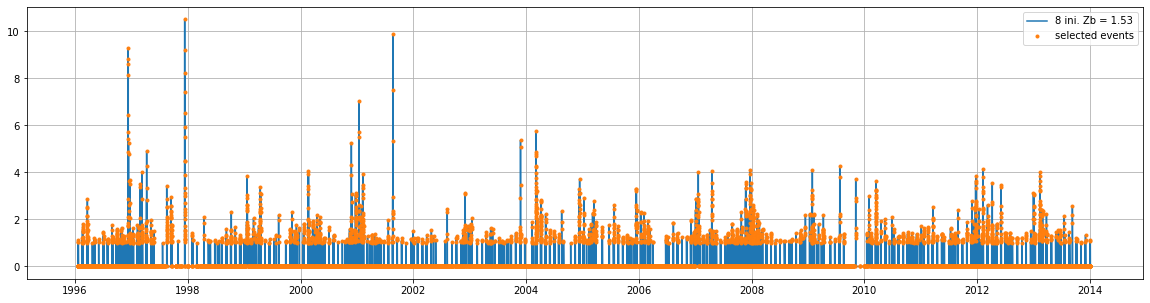

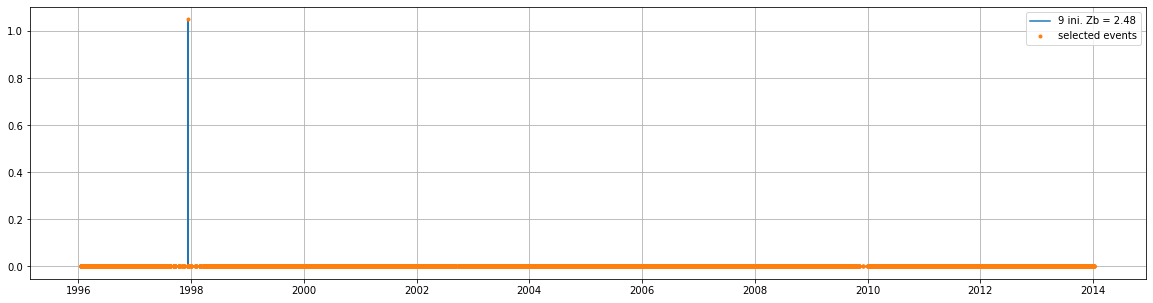

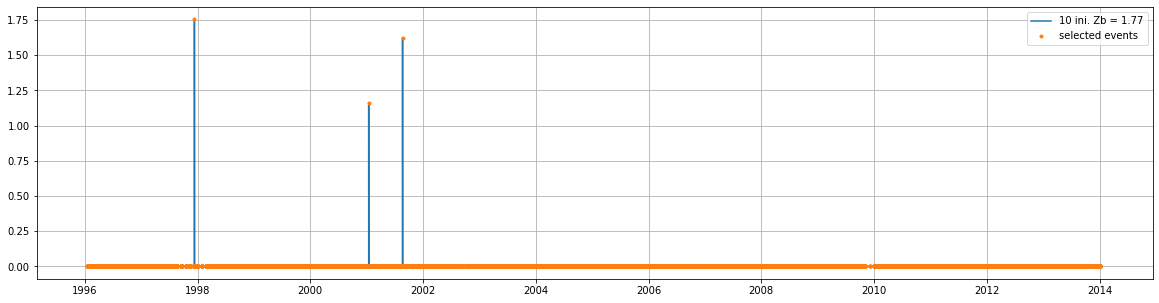

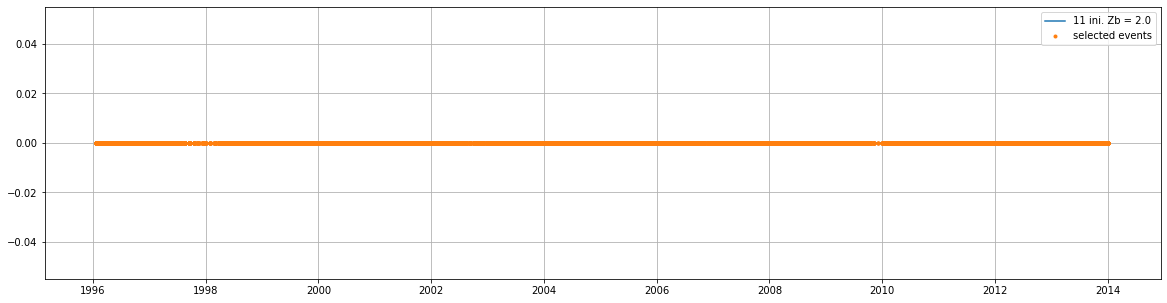

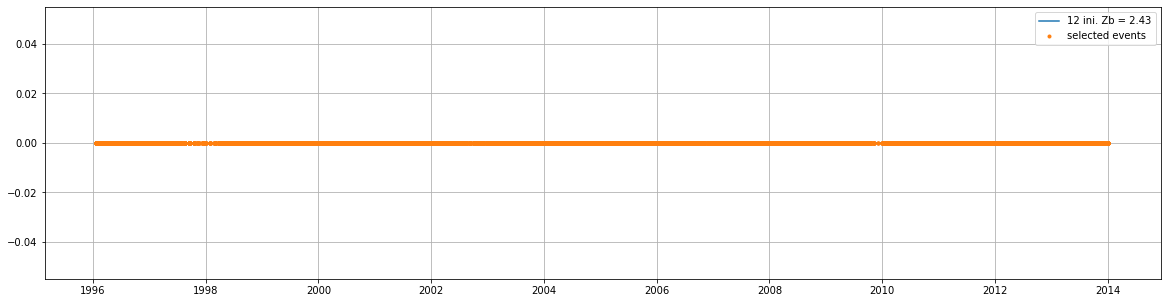

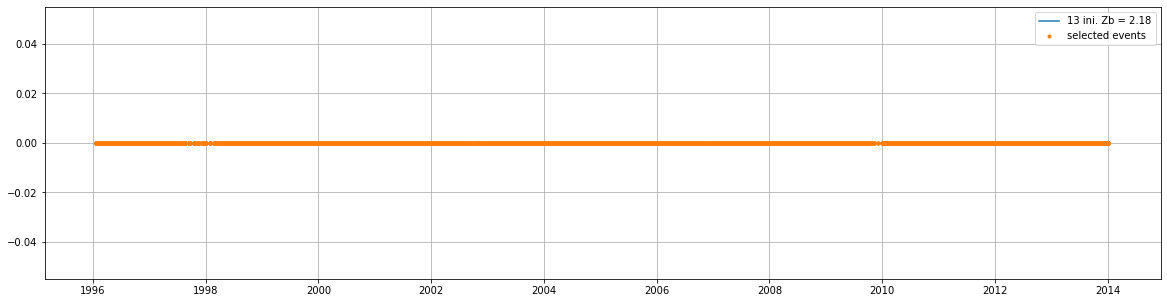

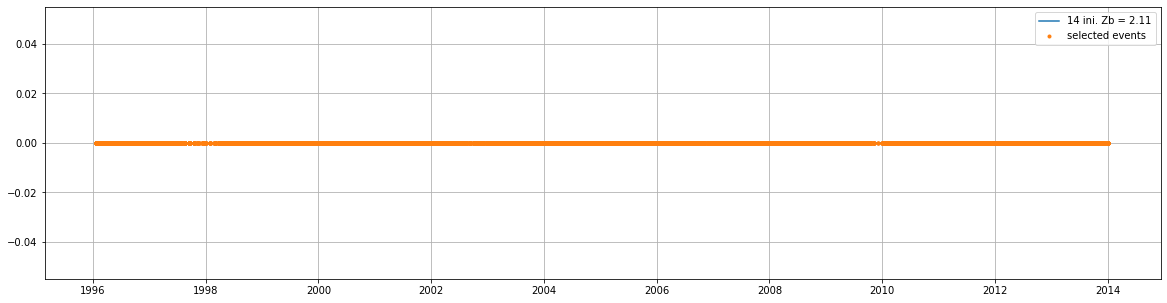

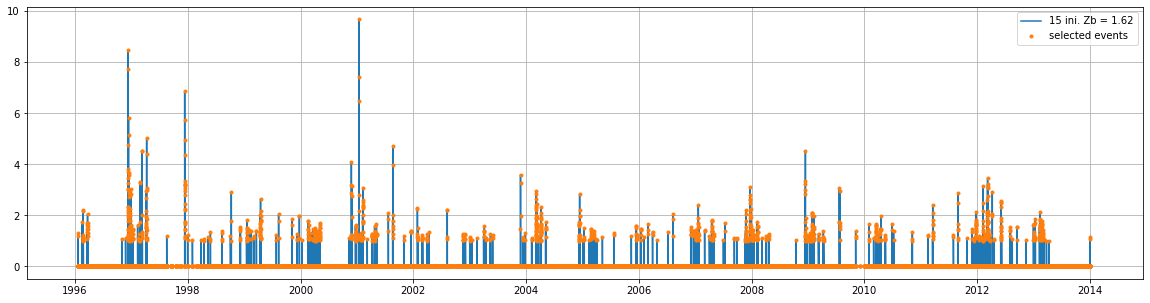

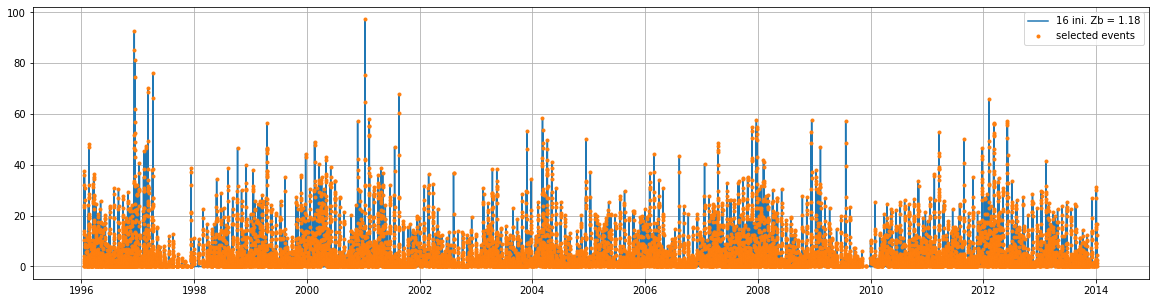

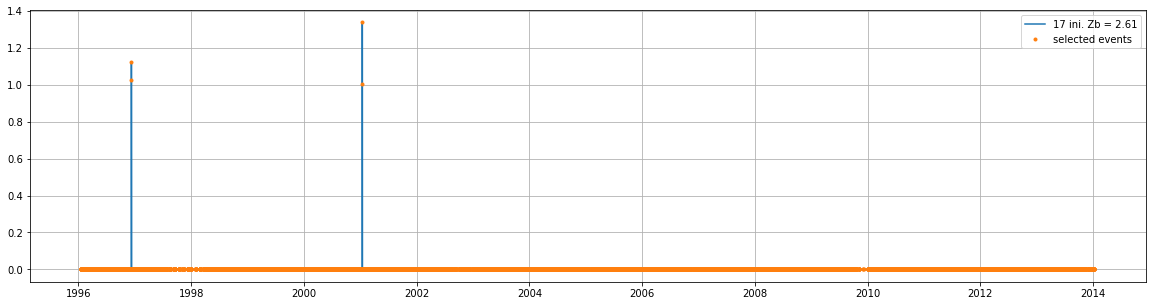

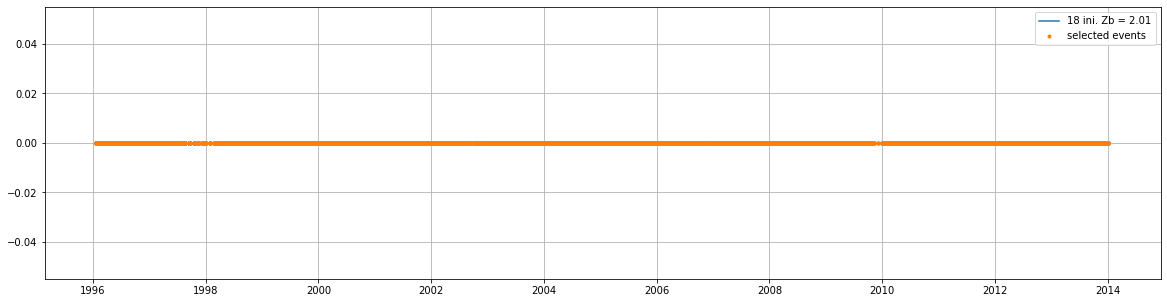

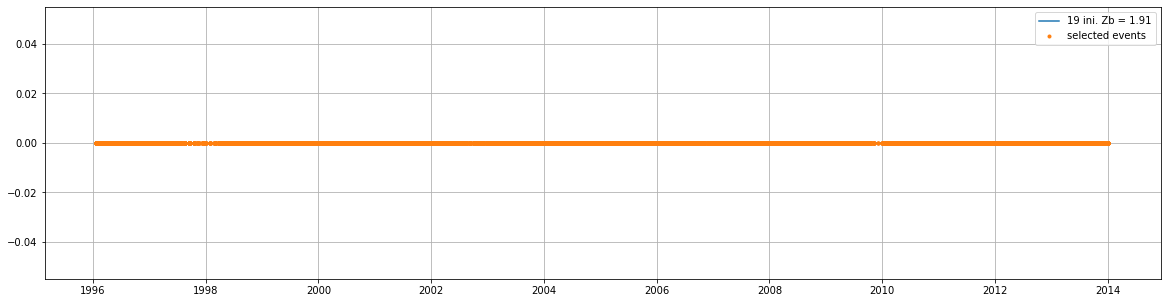

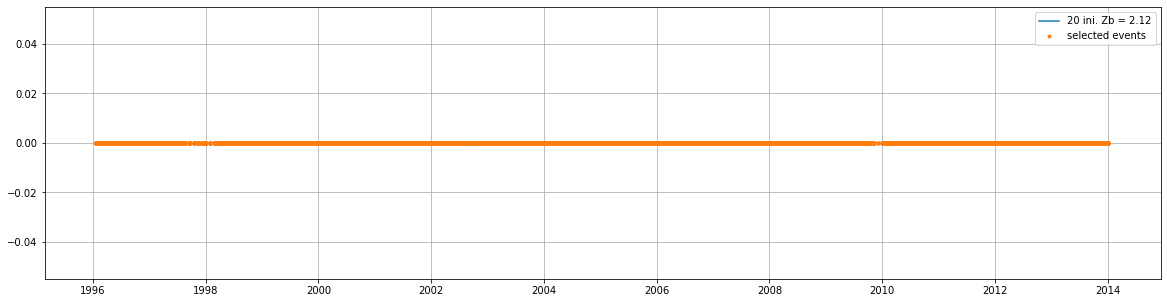

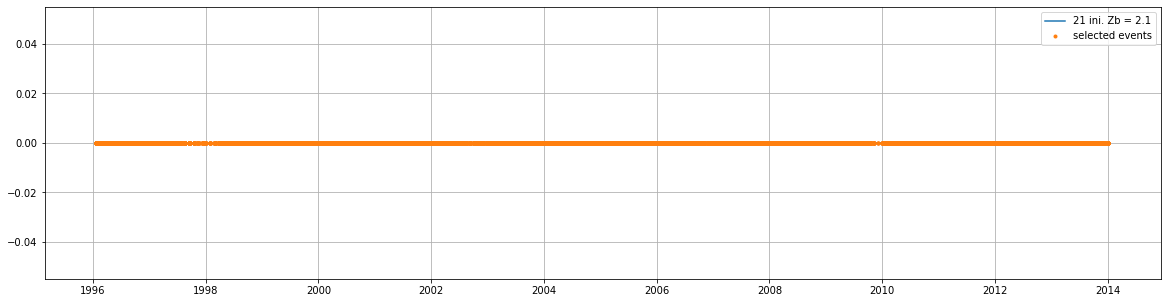

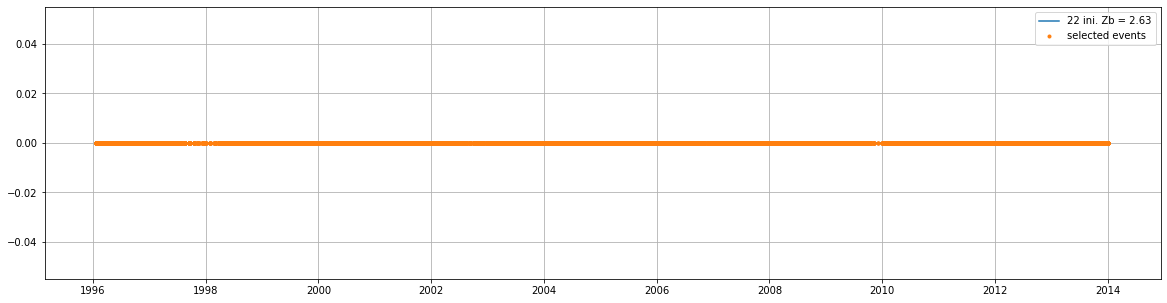

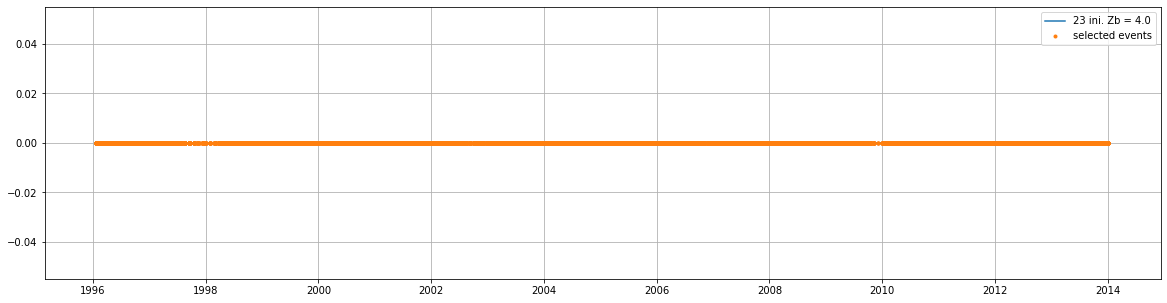

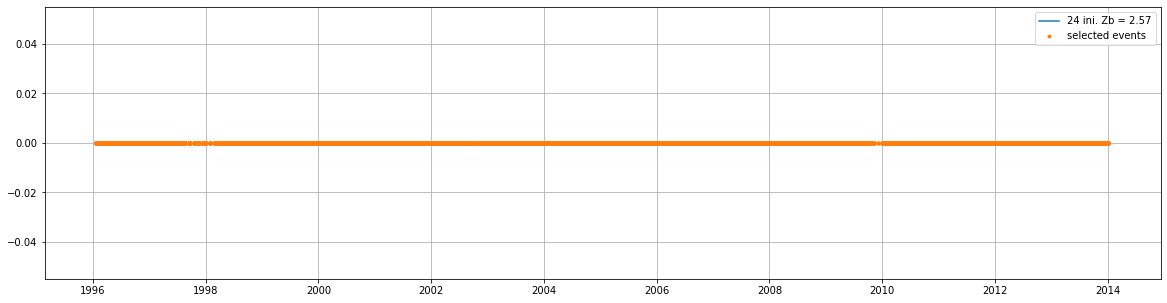

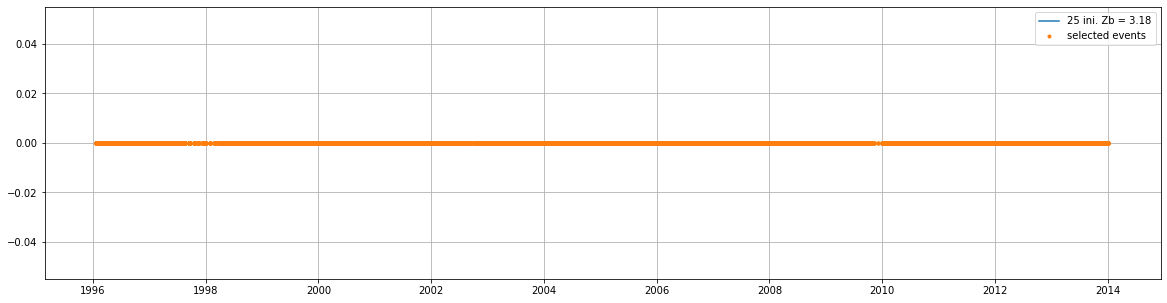

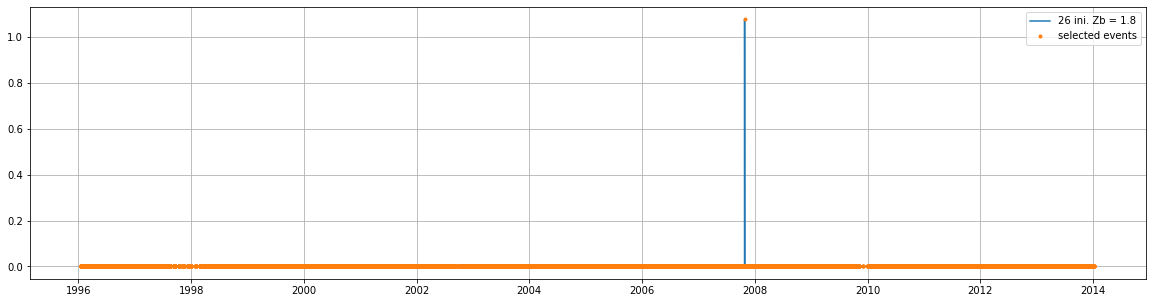

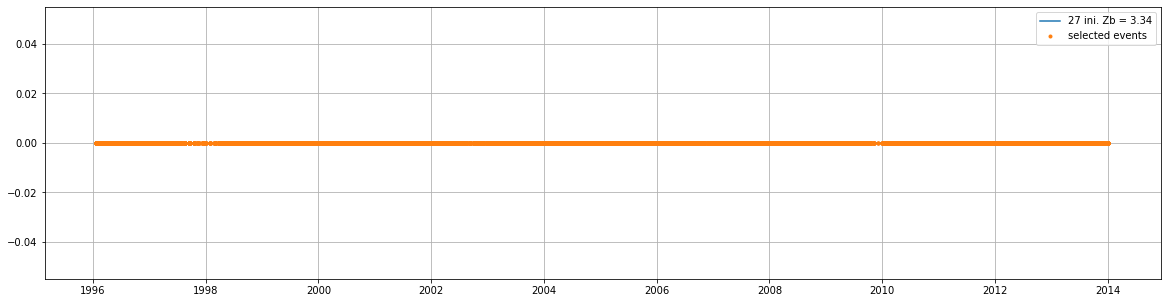

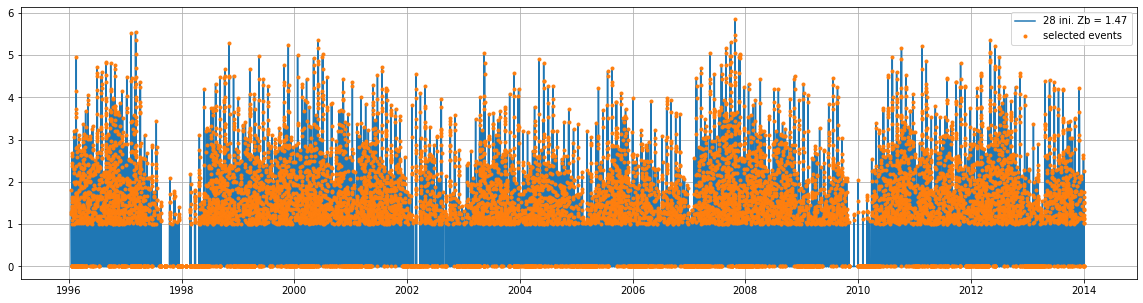

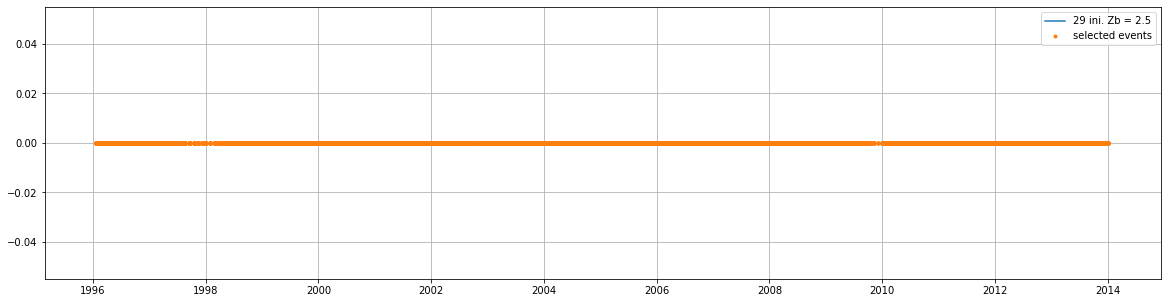

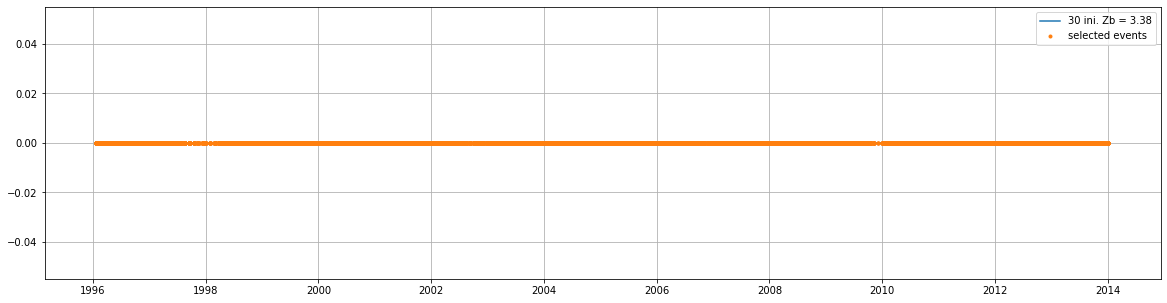

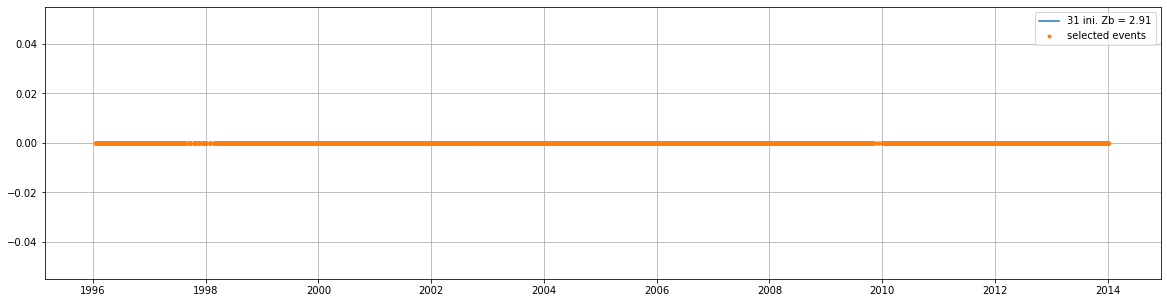

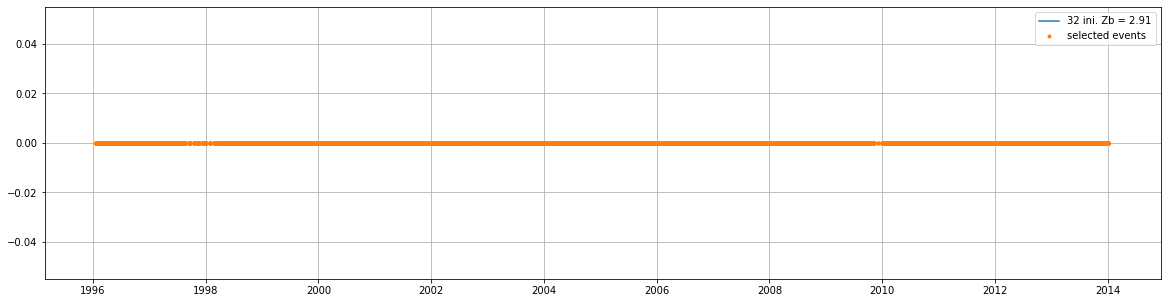

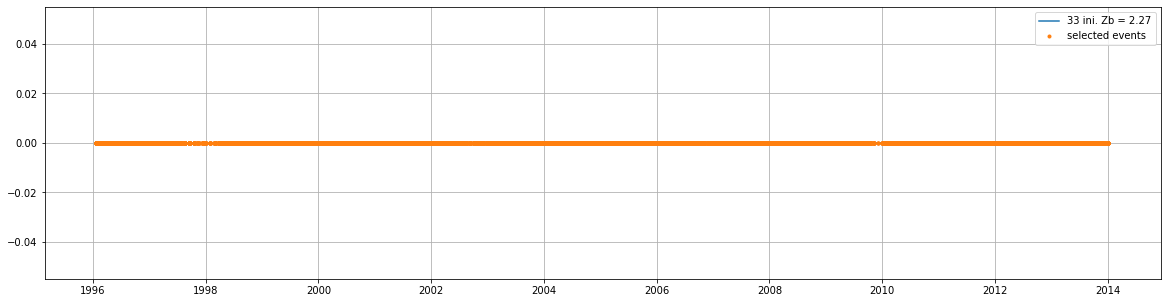

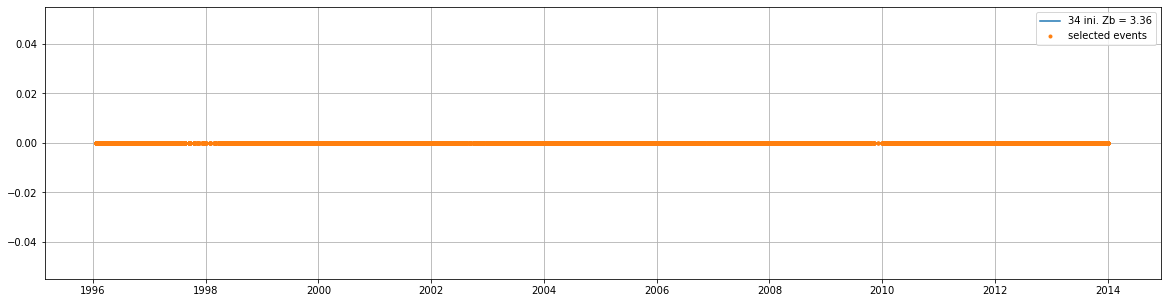

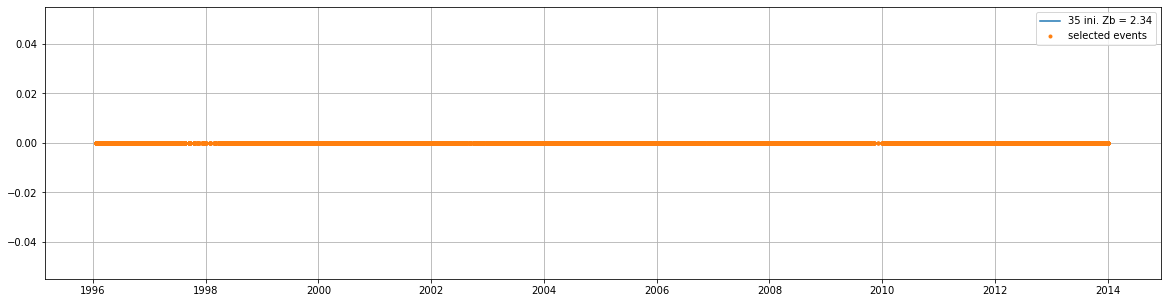

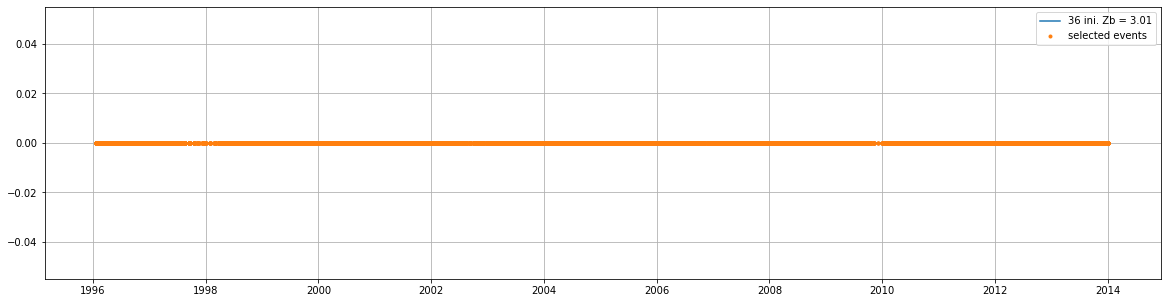

In [4]:
# plot

plt.figure(figsize=(20,10))
plt.plot(hist_Q_wavesH.time, hist_Q_wavesH.Qinv.sum(dim='profile'), label='sum all ini')
plt.plot(Q_all.time, Q_all.values, '.',label='selected events')
plt.legend()
plt.grid()

for p in range(1,37):        
    plt.figure(figsize=(20,5))
    plt.plot(hist_Q_wavesH.time, hist_Q_wavesH.Qinv.sel(profile=p), label=(str(p) + ' ini. Zb = ' + str(round(hist_Q_wavesH.Zb.sel(profile=p).values[0],2))))
    plt.plot(output.time, output.sel(profile=p), '.', label='selected events')    
    plt.legend()
    plt.grid()

sys.exit()    

SystemExit: 

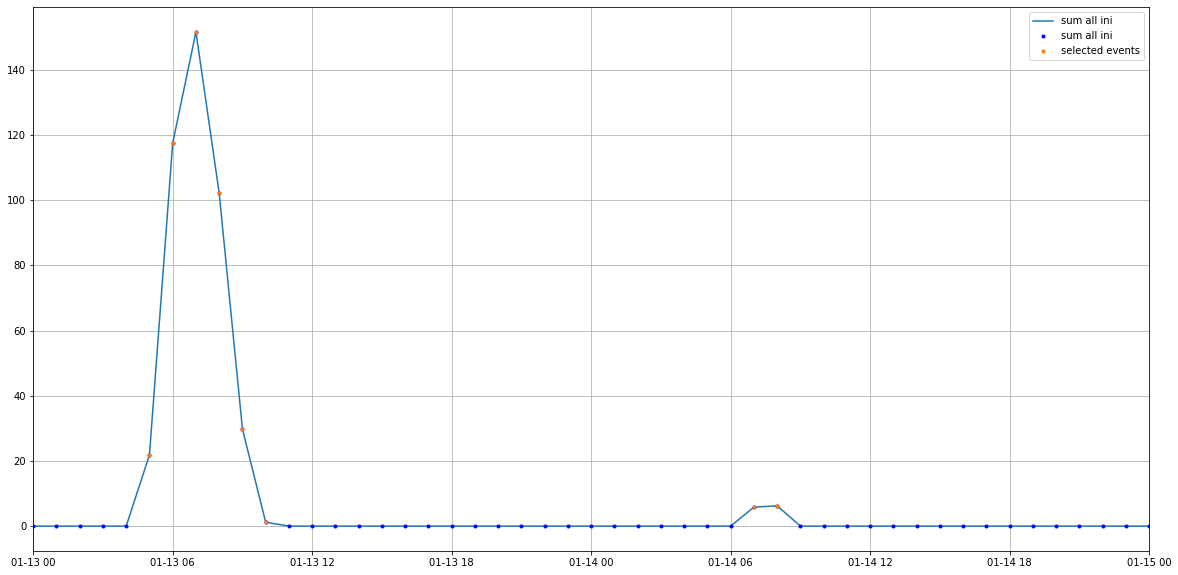

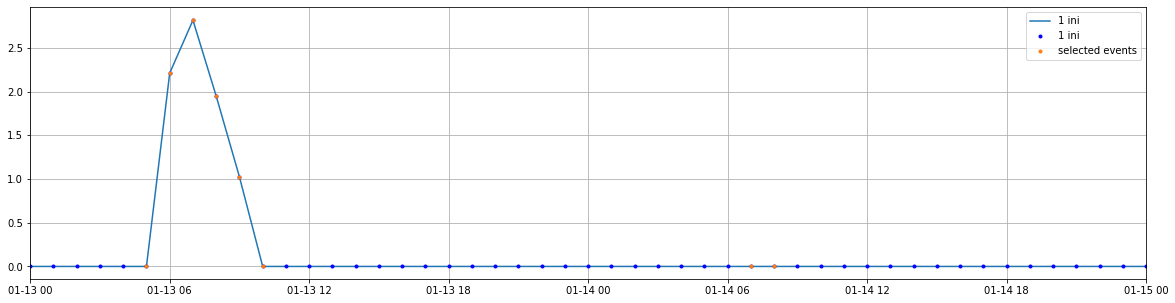

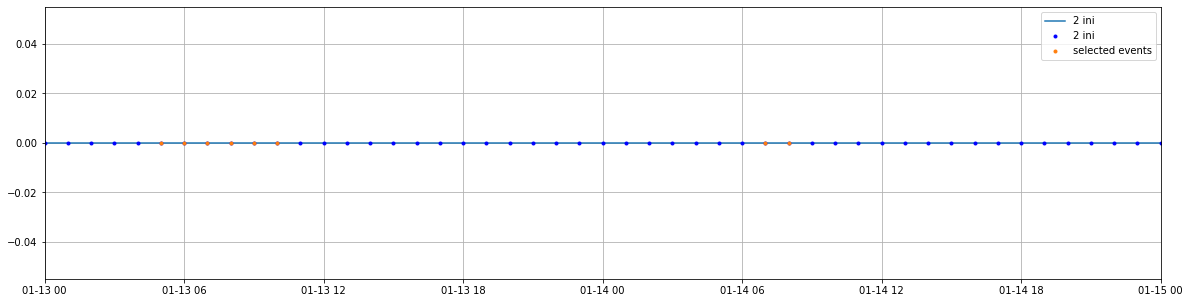

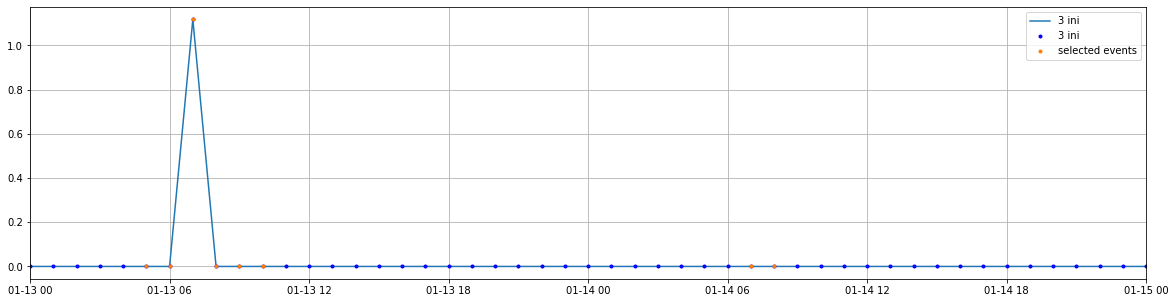

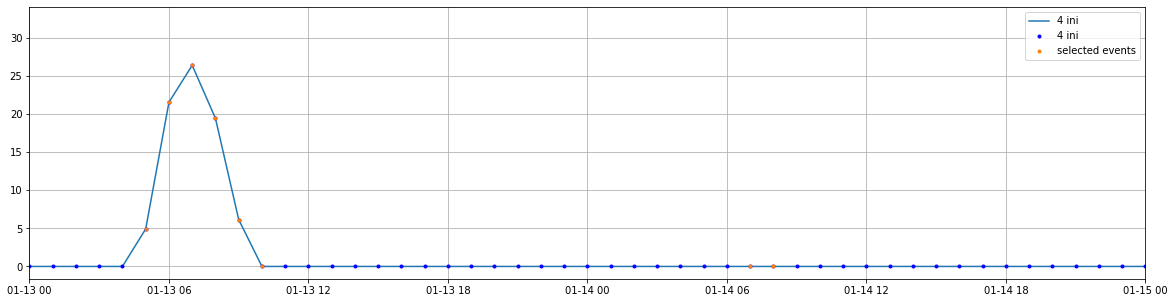

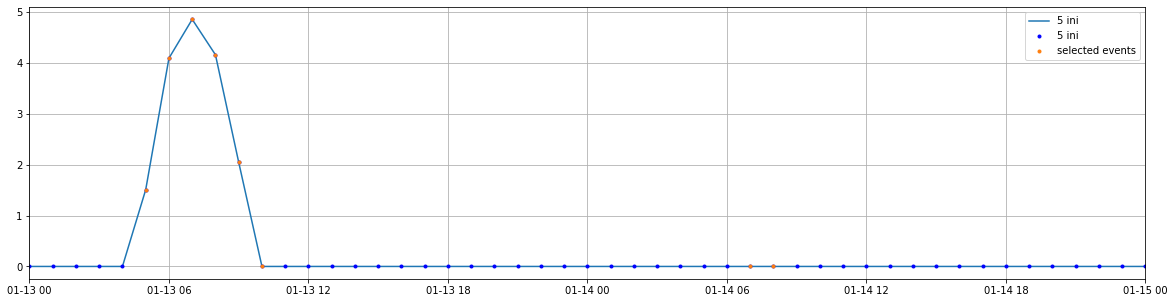

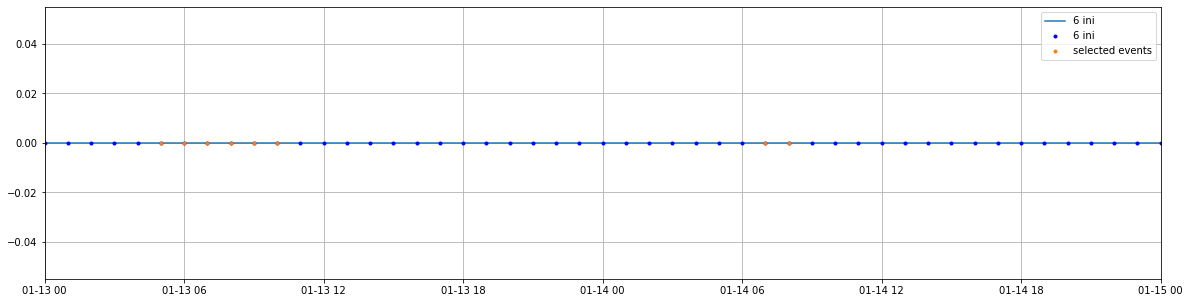

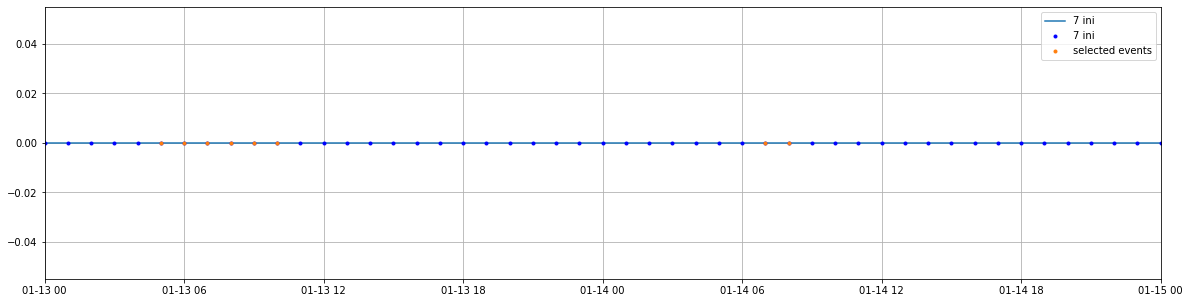

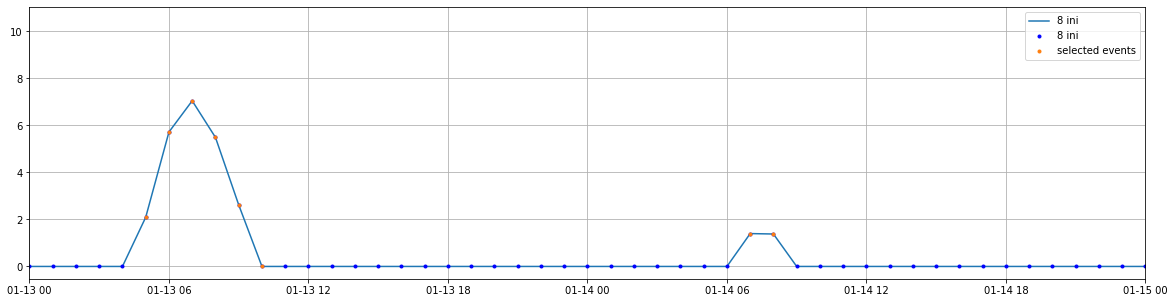

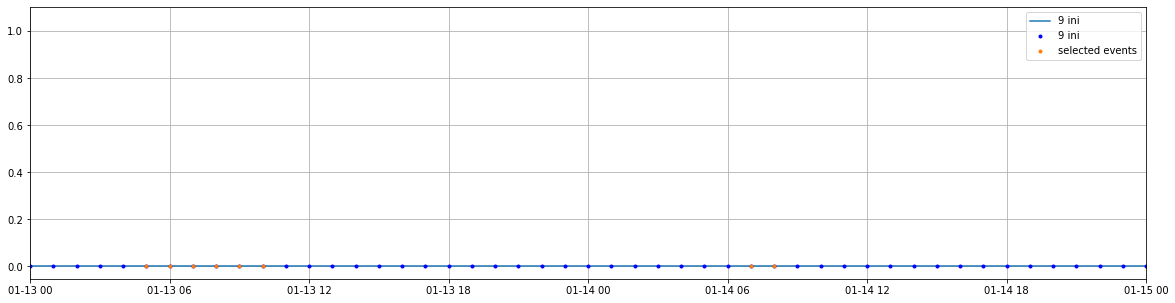

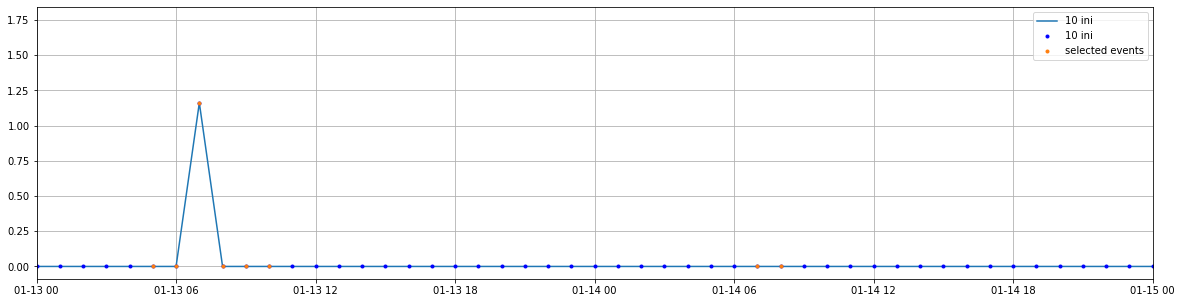

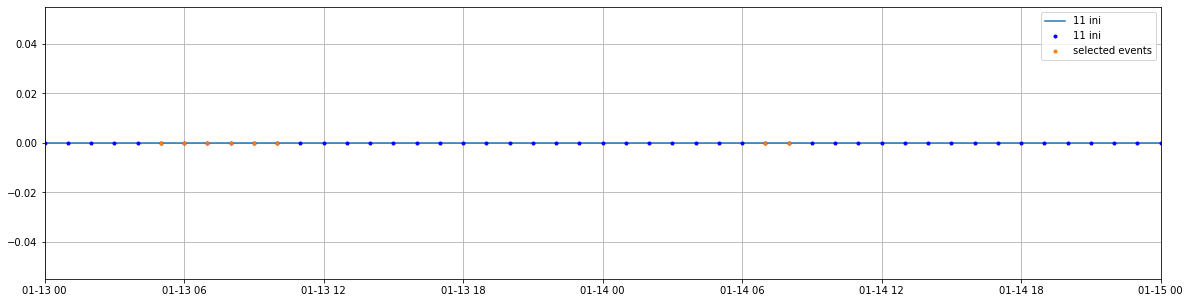

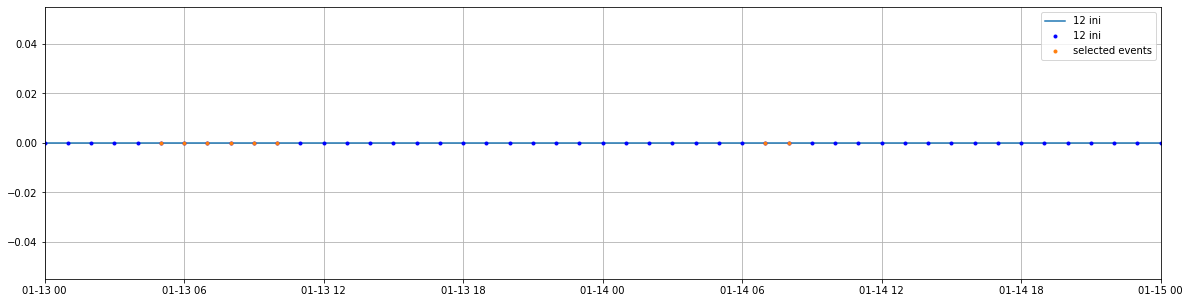

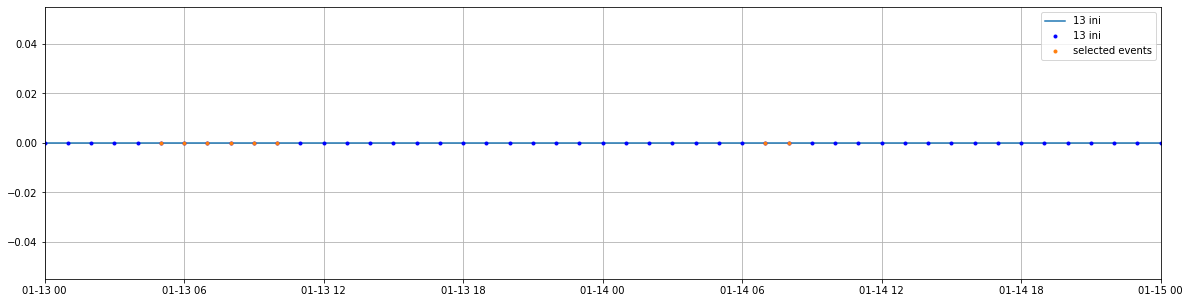

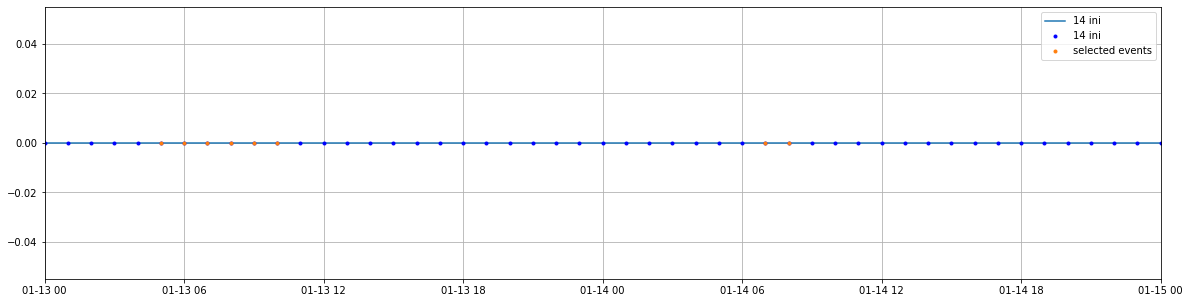

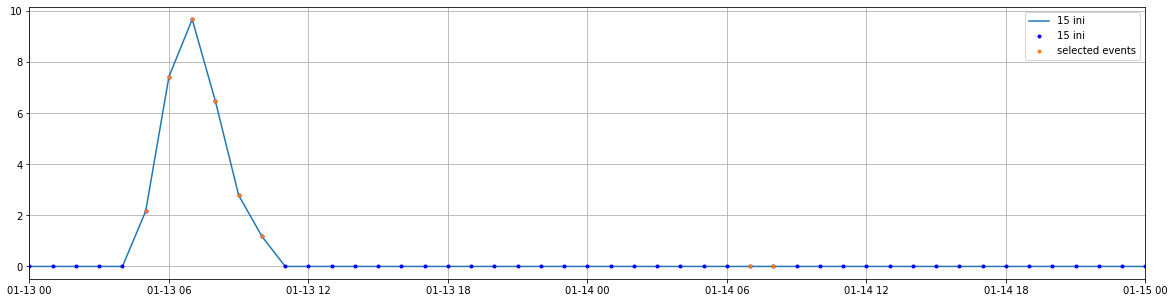

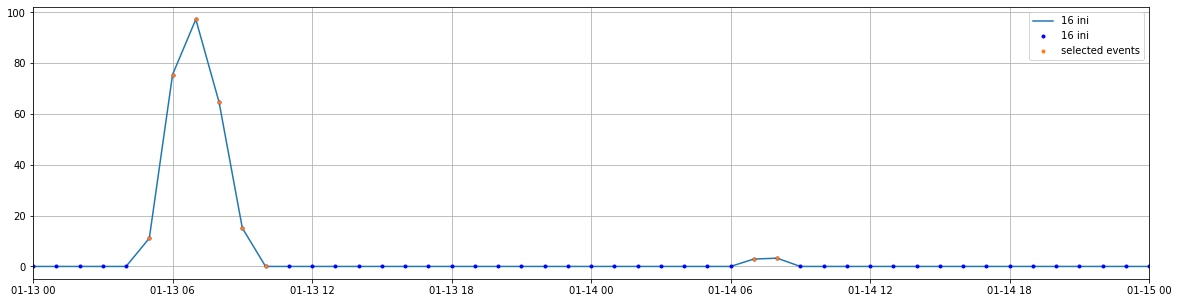

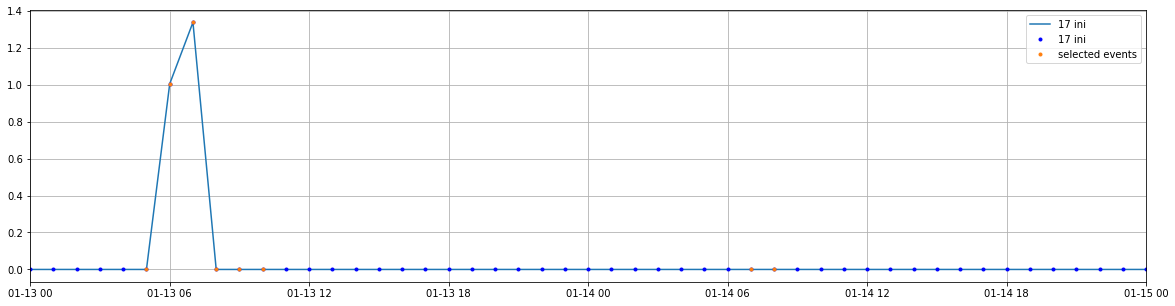

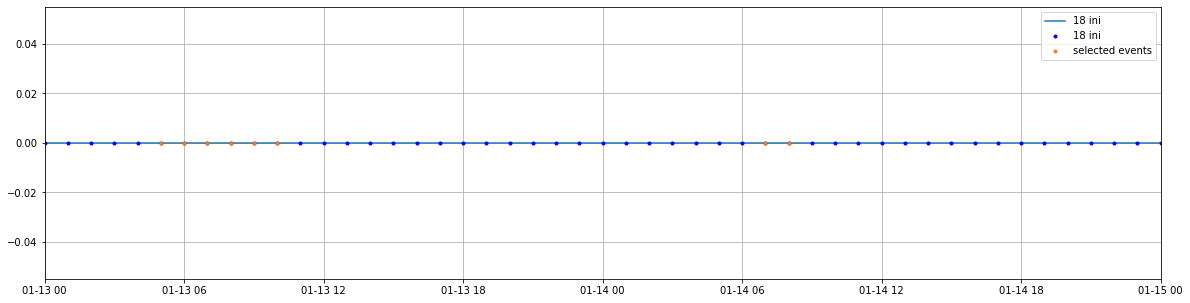

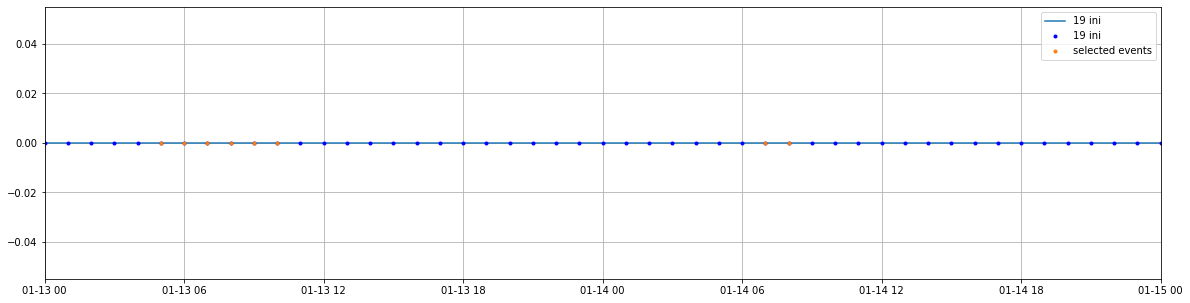

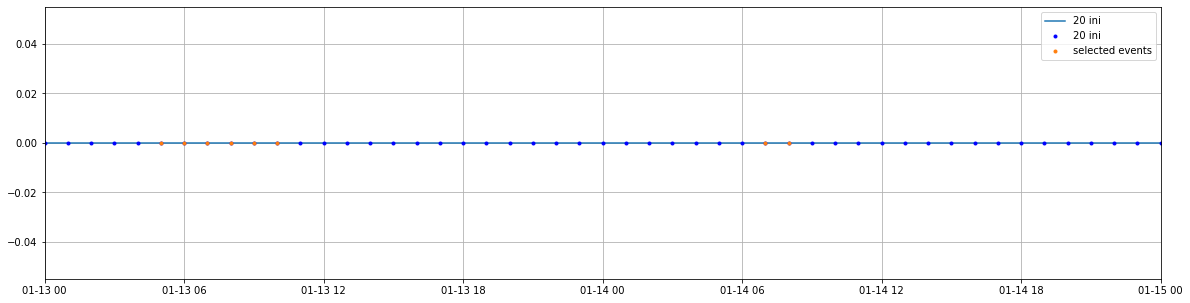

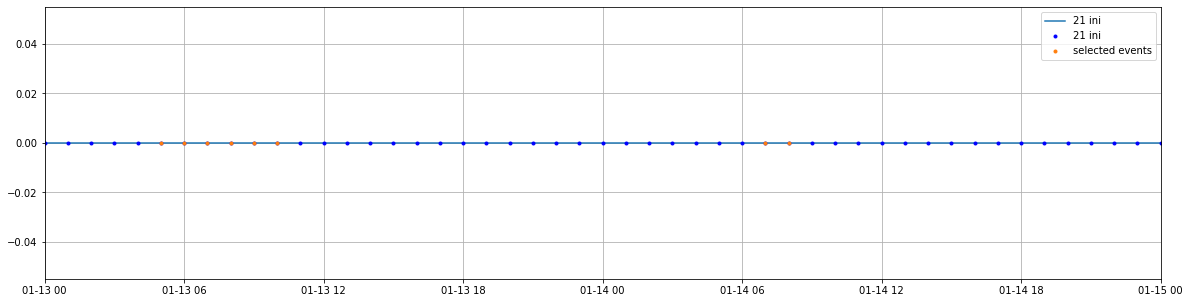

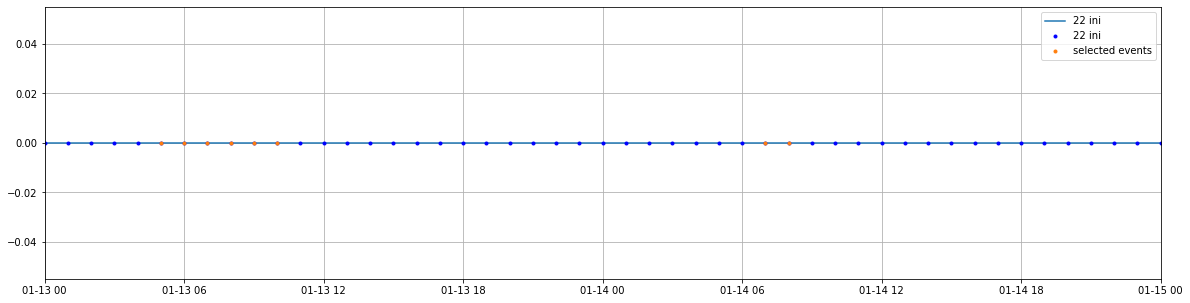

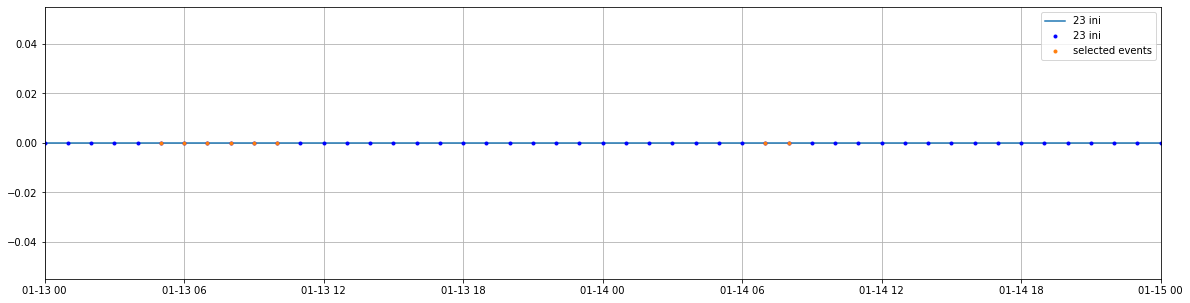

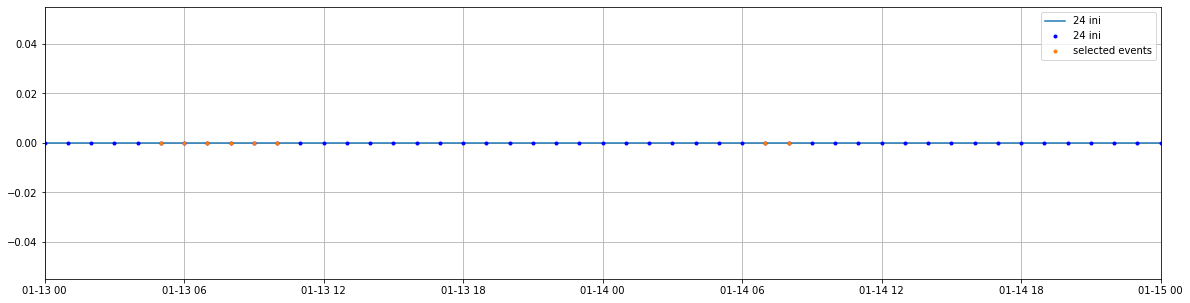

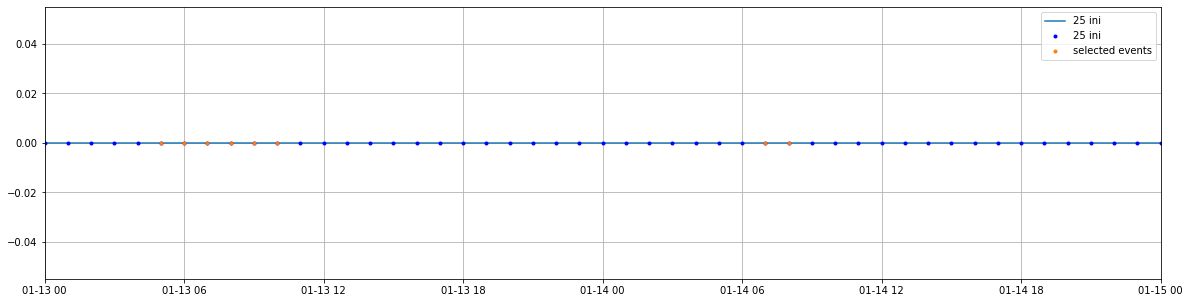

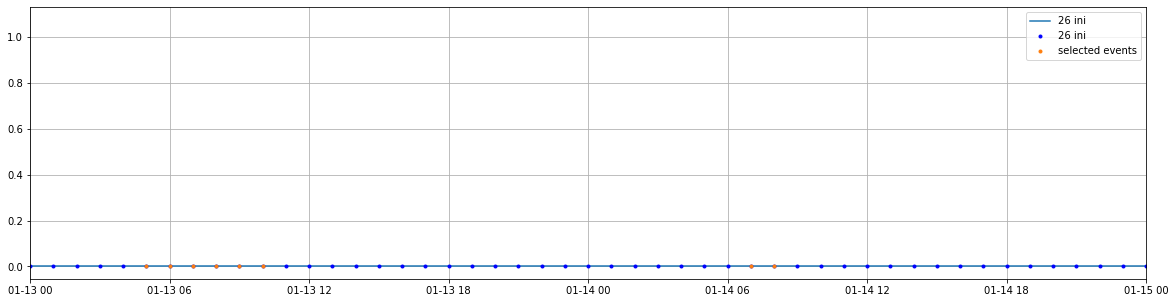

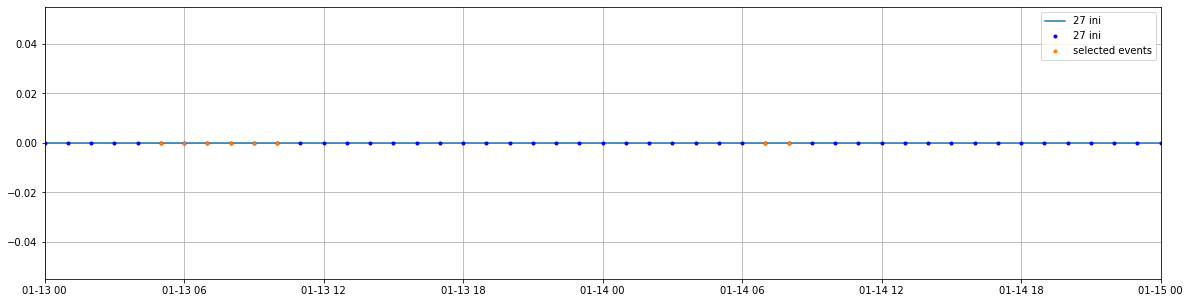

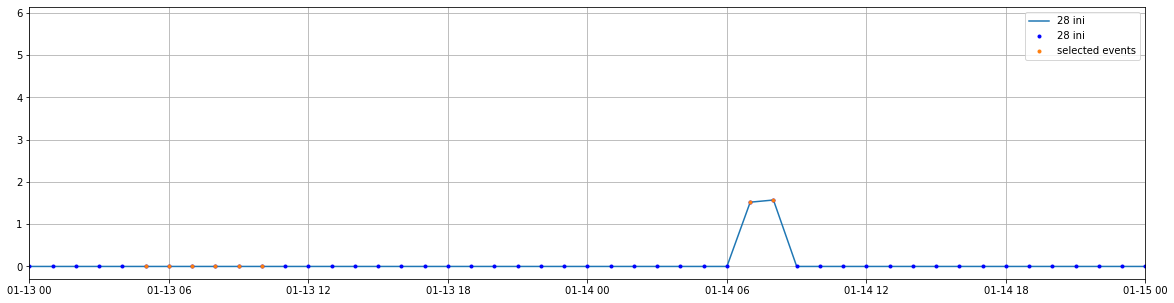

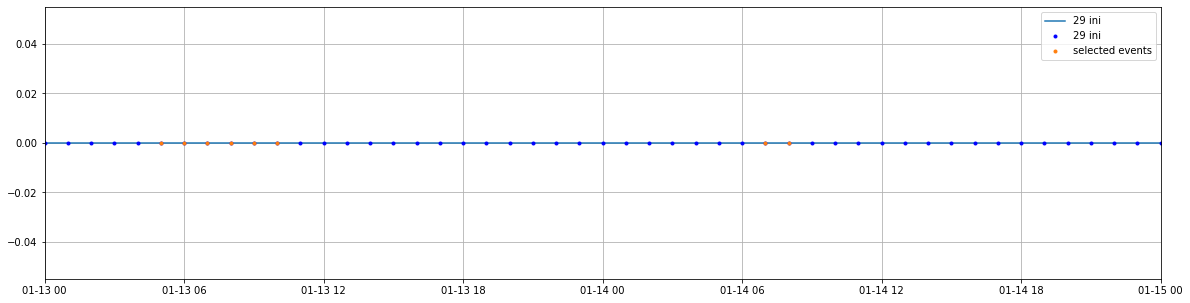

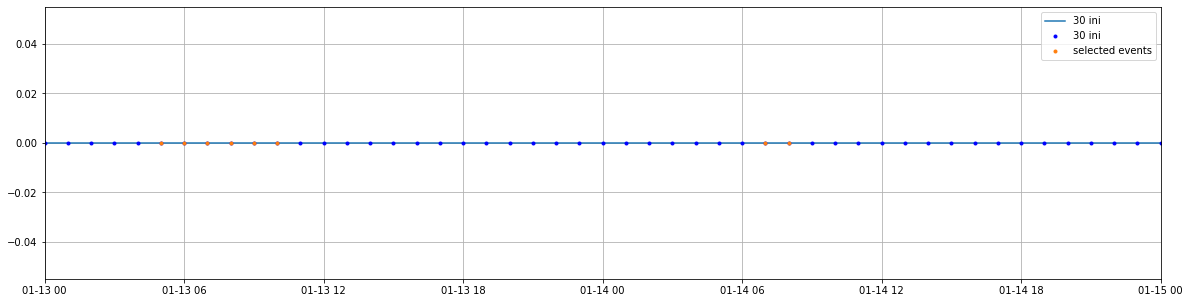

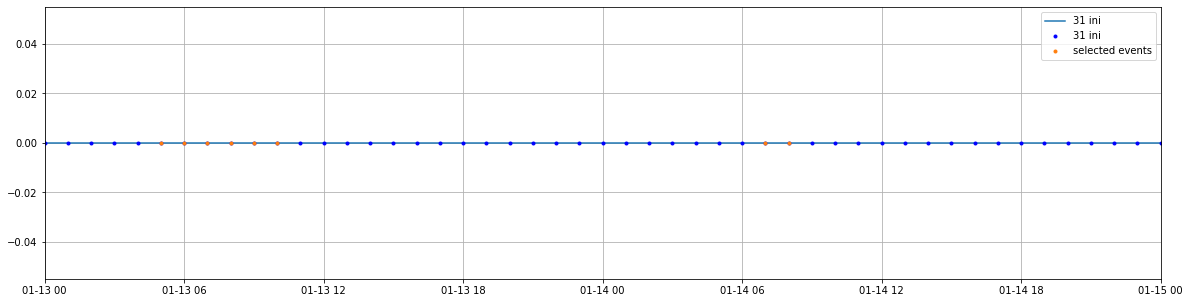

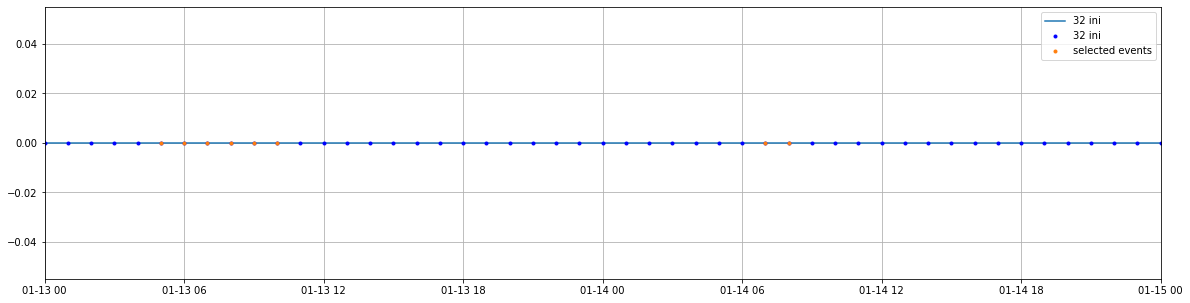

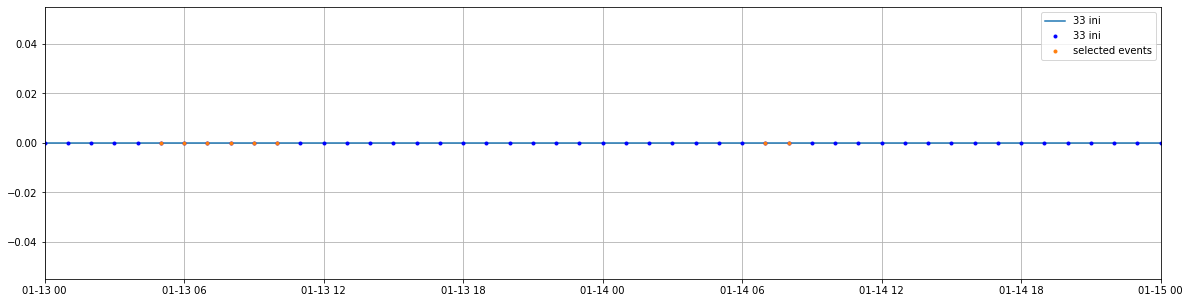

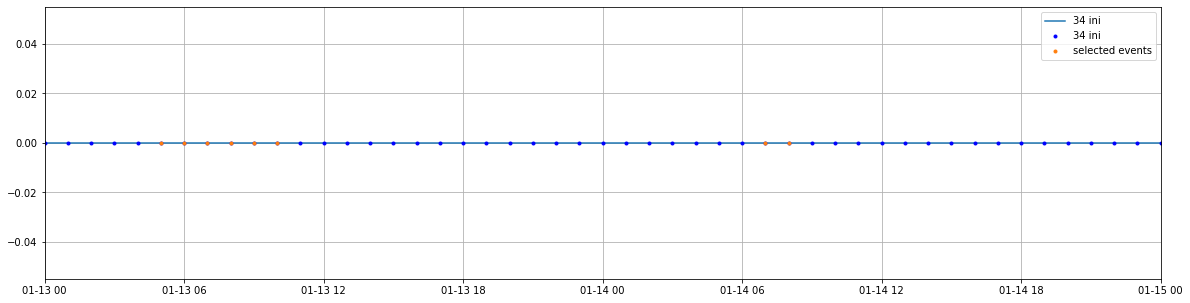

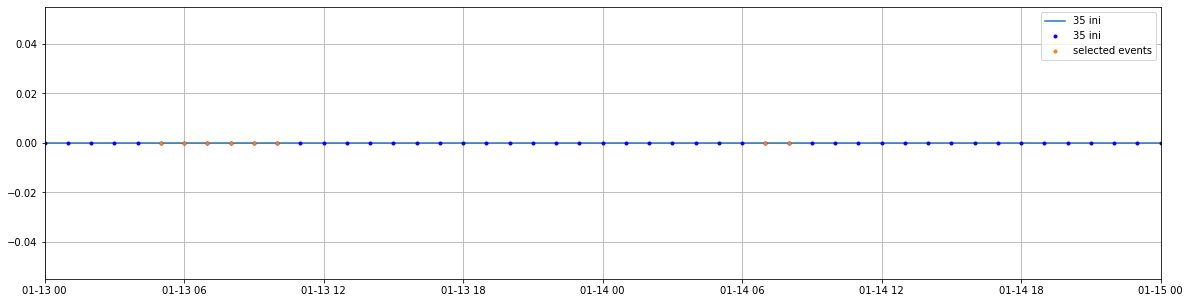

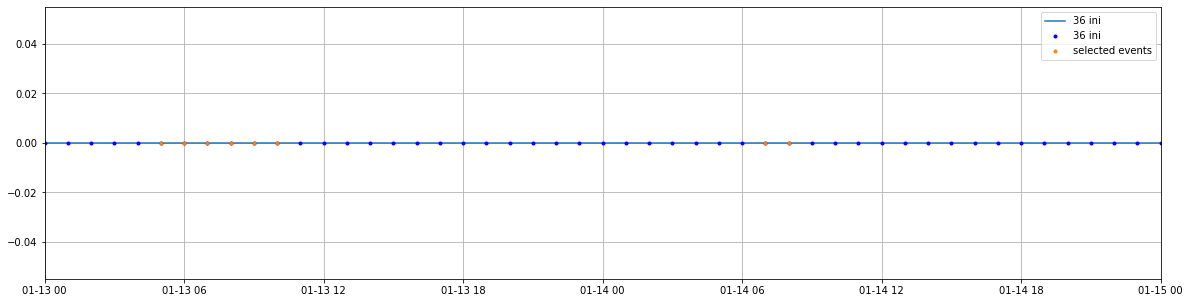

In [5]:
# plot zoom

plt.figure(figsize=(20,10))
plt.plot(hist_Q_wavesH.time, hist_Q_wavesH.Qinv.sum(dim='profile'), label='sum all ini')
plt.plot(hist_Q_wavesH.time, hist_Q_wavesH.Qinv.sum(dim='profile'),'.b', label='sum all ini')
plt.plot(Q_all.time, Q_all.values, '.',label='selected events')
plt.xlim(datetime(2001,1,13),datetime(2001,1,15))
#plt.xlim(datetime(2001,1,1),datetime(2001,2,1))
plt.legend()
plt.grid()

for p in range(1,37):
    plt.figure(figsize=(20,5))
    plt.plot(hist_Q_wavesH.time, hist_Q_wavesH.Qinv.sel(profile=p), label=(str(p) + ' ini'))
    plt.plot(hist_Q_wavesH.time, hist_Q_wavesH.Qinv.sel(profile=p), '.b', label=(str(p) + ' ini'))
    plt.plot(output.time, output.sel(profile=p), '.', label='selected events')    
    
    plt.xlim(datetime(2001,1,13),datetime(2001,1,15))
    #plt.xlim(datetime(2001,1,1),datetime(2001,2,1))
    plt.legend()
    plt.grid()

sys.exit()    

In [ ]:
#----------------------    
# Save

# from l/s/m to m3/s/m
output = output/1000 

output = output.to_dataset()
output.attrs["units"] = "m3/s/m"

sys.exit()
output.to_netcdf(op.join(p_data, 'sites/KWAJALEIN/HYCREWW/hist_Q_hydrograms.nc'))

print(output)